# Notebook pour le projet d'optimisation bi-objectif sur le stockage embarqué dans un tramway

## 1.Introduction 
Ce projet s'inscrit dans le cadre de l'optimisation bi-objectif appliquée au dimensionnement d'un système 
d'alimentation hybride pour un tramway. Le système étudié combine une ligne aérienne de contact (LAC) 
et une batterie embarquée pour améliorer les performances énergétiques et réduire les contraintes sur le réseau.

### Objectifs principaux :
1. Minimiser la capacité de la batterie, directement liée au coût du système.
2. Réduire la chute de tension maximale aux bornes du train, un indicateur clé de la robustesse du réseau d'alimentation.

### Contexte :
Lors des phases de freinage, une partie de l'énergie mécanique peut être récupérée grâce à une batterie embarquée. 
Cette énergie stockée est ensuite réutilisée pour alimenter le train lors des phases de traction, 
permettant ainsi de réduire les appels de puissance sur la ligne aérienne de contact. 
Cependant, le dimensionnement optimal de cette batterie et la mise en place d'une stratégie de gestion efficace 
sont des défis complexes nécessitant des approches avancées telles que la simulation et l'optimisation multi-critères.

### Plan du Notebook :
1. Simulation de la ligne de tramway sans batterie pour établir une base de référence.
2. Ajout et simulation d'un système de stockage pour observer ses impacts.
3. Mise en œuvre de méthodes d'optimisation (Monte Carlo et NSGA-II) pour identifier les solutions optimales.
4. Analyse et interprétation des résultats obtenus.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from Functions import simulation_sys

## 2.Mise en place du modèle du système 

Modèle électrique du système quand le train est à la position x : 

![Modèle électrique du système quand le train est à la position x](Model.png)

### 2.1.Mise en place sans système de stockage


Extraction des données du fichier 

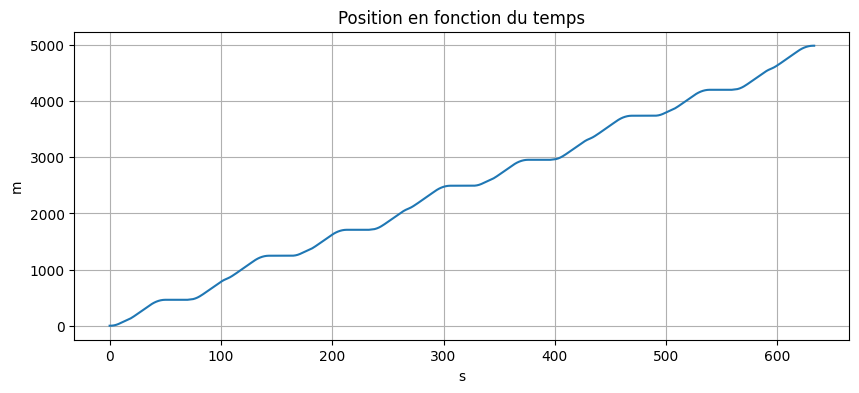

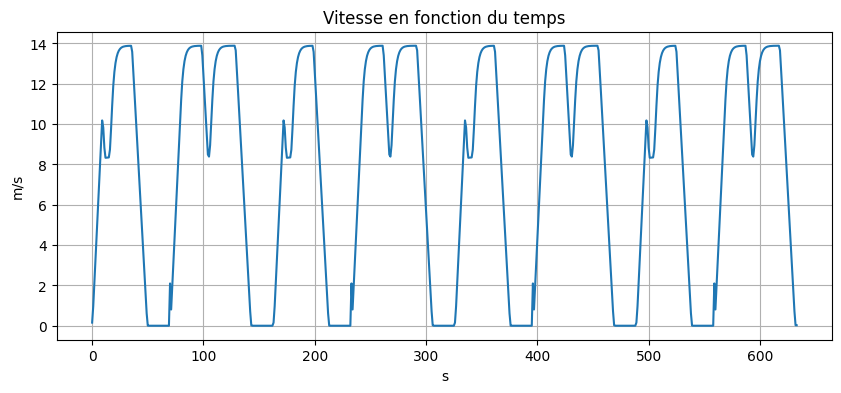

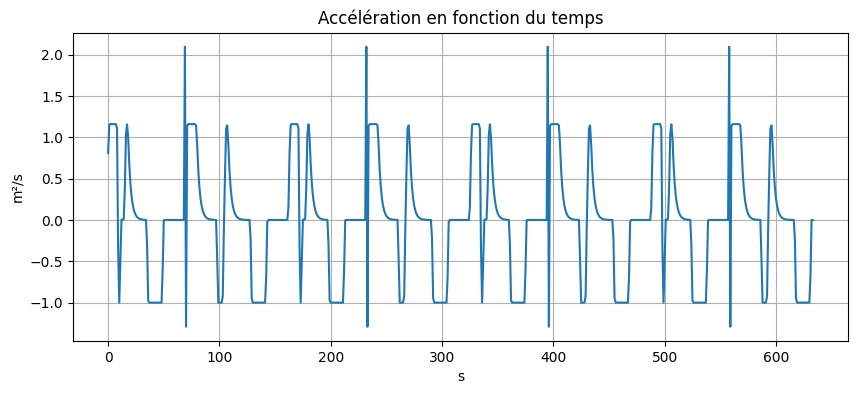

In [2]:
# Ouvrir le fichier en mode lecture
with open("marche.txt", "r") as f:
    data = f.readlines()  # Liste contenant chaque ligne du fichier

#Supprimer les sauts de ligne
data = [ligne.strip().split('\t') for ligne in data]

#Extraction des vecteurs temps et position 
temps = [t[0] for t in data]    
position = [x[1] for x in data]

#Convertir les vecteur en float et les stocker dans des np.array afin de faciliter leurs utilisation 
position = np.array(list(map(float, position)))
temps = np.array(list(map(int, temps)))

#Calcul de la vitesse par differenciation de la position 
vitesse =[position[i+1]-position[i] for i in range(len(position)-1)]
#Réguler la taille du vvecteur 
vitesse.append(vitesse[-1])
vitesse = np.array(vitesse)

#Calcul de l'accélération par différenciation de la vitesse 
acc =[vitesse[i+1]-vitesse[i] for i in range(len(vitesse)-1)]
acc.append(acc[-1])
acc = np.array(acc)


plt.figure(figsize=(10,4))
plt.plot(temps,position) 
plt.xlabel('s')
plt.ylabel('m')
plt.title("Position en fonction du temps") 
plt.grid()

plt.figure(figsize=(10,4))
plt.plot(temps,vitesse)
plt.xlabel('s')
plt.ylabel('m/s')
plt.title("Vitesse en fonction du temps") 
plt.grid()

plt.figure(figsize=(10,4))
plt.plot(temps,acc)
plt.xlabel('s')
plt.ylabel('m²/s')
plt.title("Accélération en fonction du temps") 
plt.grid()


Calcul de la puissance consommée par le train en utilisant les différentes formules données dans l'énnoncé 

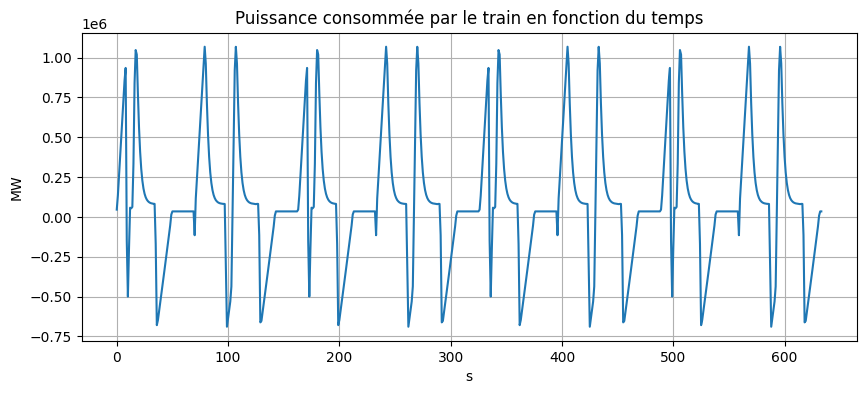

In [3]:
# Constante 
M=70*1000  # Conversion tonne/kg
A0 = 780
A1 = 6.4/1000   # Conversion tonne/kg
B0 = 0
B1 = 3.6*0.14/1000  # Conversion tonne/kg et kmh/ms
C0 = 0.3634*(3.6)**2 #Conversion kmh/ms
C1=0
rend =0.8

#Calcul  de la forc motrice d'abord 
Fr= (A0 + A1*M) + (B0 + B1*M)*vitesse +(C0 + C1*M)*vitesse**2
Fmot = M*acc + Fr
#Puis la puissance mécanique électrique 
Pmec = Fmot*vitesse
Pelec = np.array([Pmec[i]/rend if Pmec[i] >=0 else Pmec[i]*rend for i in range(len(vitesse))])

Ptrain = Pelec + 35*1000


plt.figure(figsize=(10,4))
plt.plot(temps,Ptrain)
plt.title("Puissance consommée par le train en fonction du temps") 
plt.xlabel('s')
plt.ylabel('MW')
plt.grid()
plt.show() 

Calcul de la chute de la tension aux bornes du train afin de déduire la chute de tension 

C:\Users\khodj\AppData\Local\Temp\ipykernel_24136\654079719.py:14: RuntimeWarning: invalid value encountered in sqrt
  Vtrain = 0.5*Vsst + 0.5*np.sqrt(Vsst**2 - 4*Req*Ptrain)


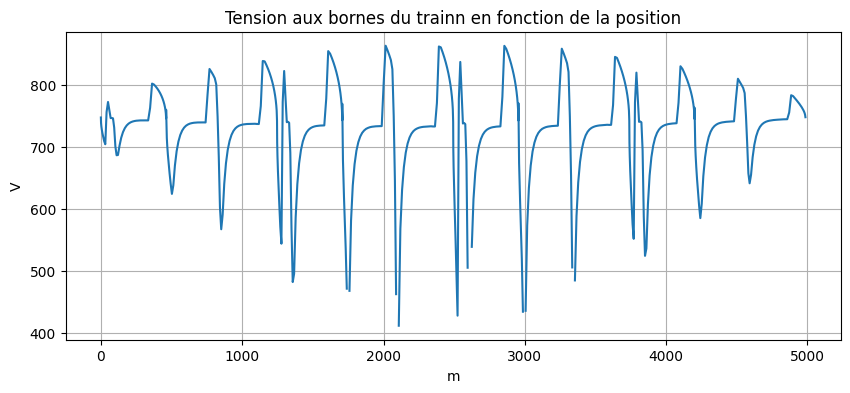

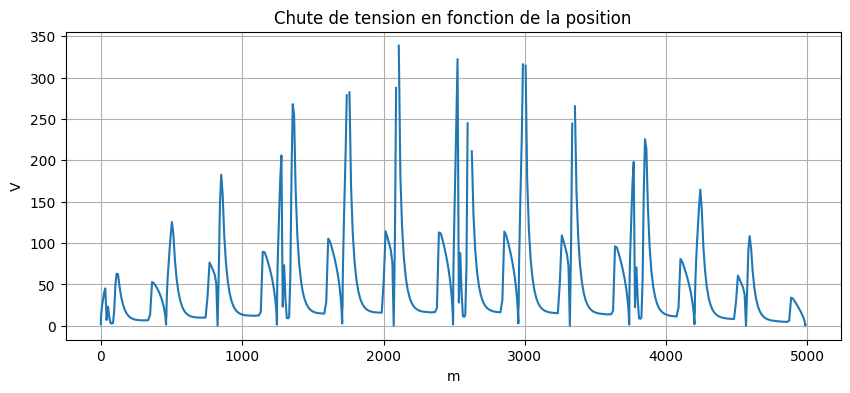

In [4]:
#Connstantes 
Rsst = 33e-3
rolac = 95e-6   #Ajustement pour la deuxième partie 
rorail = 10e-6  #Ajustement pour la deuxième partie 
Rlac1 = rolac*position 
Rlac2 = rolac*(position[-1]-position)
Rrail1 = rorail*position
Rrail2 = rorail*(position[-1]-position)
Vsst=750

#Résistance équivalente 
Req =  (Rsst + Rrail1 + Rlac1)*(Rsst + Rrail2 + Rlac2)/(2*Rsst + Rrail1 + Rlac1 + Rrail2 + Rlac2)
#Tension Vttrain
Vtrain = 0.5*Vsst + 0.5*np.sqrt(Vsst**2 - 4*Req*Ptrain)
#Chute de tensionn 
chute = np.array([abs(Vsst - v) for v in Vtrain])

plt.figure(figsize=(10,4))
plt.plot(position,Vtrain)
plt.title('Tension aux bornes du trainn en fonction de la position')
plt.xlabel('m')
plt.ylabel('V')
plt.grid()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(position,chute)
plt.title('Chute de tension en fonction de la position')
plt.xlabel('m')
plt.ylabel('V')
plt.grid()
plt.show()

**Remarque :**
- Selon la représentation de la chute de tension, on remarque des discontinuités qui sont du au non respect de la valeur de Plac tel que : $P_{LAC} > \dfrac{V_{sst}^2}{4 R_{eq}}$ 
- On remarque ainsi une grande chute de tension (environ 360V) qui dépasse la limite autorisé de 100V au maximum. 
- Dans un second temps la batterie va intervenir afin de diminuer la cute de tension.

Calcul et affichage de l'énergie du train à partir de l'intégration de la puissance déjà calculée en utilisant la méthode d'integgral de trapèze 

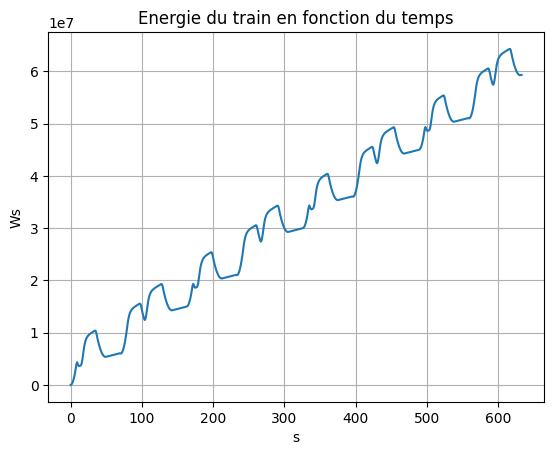

In [5]:
# Calcul de l'intégrale cumulée avec numpy (methode des trapezes)
Etrain = np.cumsum(np.diff(temps) * (Ptrain[:-1] + Ptrain[1:]) / 2)
# On ajoute un 0 initial pour que l'intégrale commence à 0
Etrain = np.insert(Etrain, 0, 0)

plt.figure()
plt.plot(temps,Etrain)
plt.title("Energie du train en fonction du temps")
plt.xlabel('s')
plt.ylabel('Ws')
plt.grid()
plt.show()

**Remarque** 
- On remarque une grande perte d'énergie durant le freinage à plusiieurs reprise, on va utiliser cette énergie perdue pour charger la batterie qui sera ajouter 

### 2.2.Mise en place avec système de stockage

Circuit simplifié  montrant le système train + batterie + rhéostat 

![Flux de puissance de l’alimentation hybride LAC/batterie](batterie.png)

#### 2.2.1.Test du bon fonctionnement de l'algorithme 
- Dans cette partie, une valeur approximative de la cappacité de la batterie est prise afin de tester le bon fonctionnement dee l'algorithme developpée dans le but de simuler le trjet du Tramway avec système de stockage 
- Cet algorithme sera mis dans ue fonction **simulation_sys**, située dans le fichier **Functions.py** afin de simplifier son utilisation dans les algorithmes génétiques  
- Un rendement de 90 % de la batterie signifie que seulement 90 % de l’énergie entrée ou disponible est utilisable sous forme d’énergie utile, tandis que les 10 % restants sont perdus sous forme de chaleur ou d'autres pertes internes (effet Joule, résistance interne, etc.).
- Charge de la batterie : Si 100 Wh d’énergie est fournis, avec un rendement de 90 %, la batterie n’emmagasinera que 90 Wh sous forme d’énergie utilisable.
- Décharge de la batterie : Lors de la décharge, si la batterie restitue cette énergie, que 90 % de l’énergie emmagasinée est récupérable, donc environ 81 Wh utilisables sur les 100 Wh initialement fournis.
 

L'énnergie de la batterie a depassé la capacité, remise à niveau
L'énnergie de la batterie a depassé la capacité, remise à niveau
L'énnergie de la batterie a depassé la capacité, remise à niveau
L'énnergie de la batterie a depassé la capacité, remise à niveau
L'énnergie de la batterie a depassé la capacité, remise à niveau
L'énnergie de la batterie a depassé la capacité, remise à niveau
L'énnergie de la batterie a depassé la capacité, remise à niveau
L'énnergie de la batterie a depassé la capacité, remise à niveau


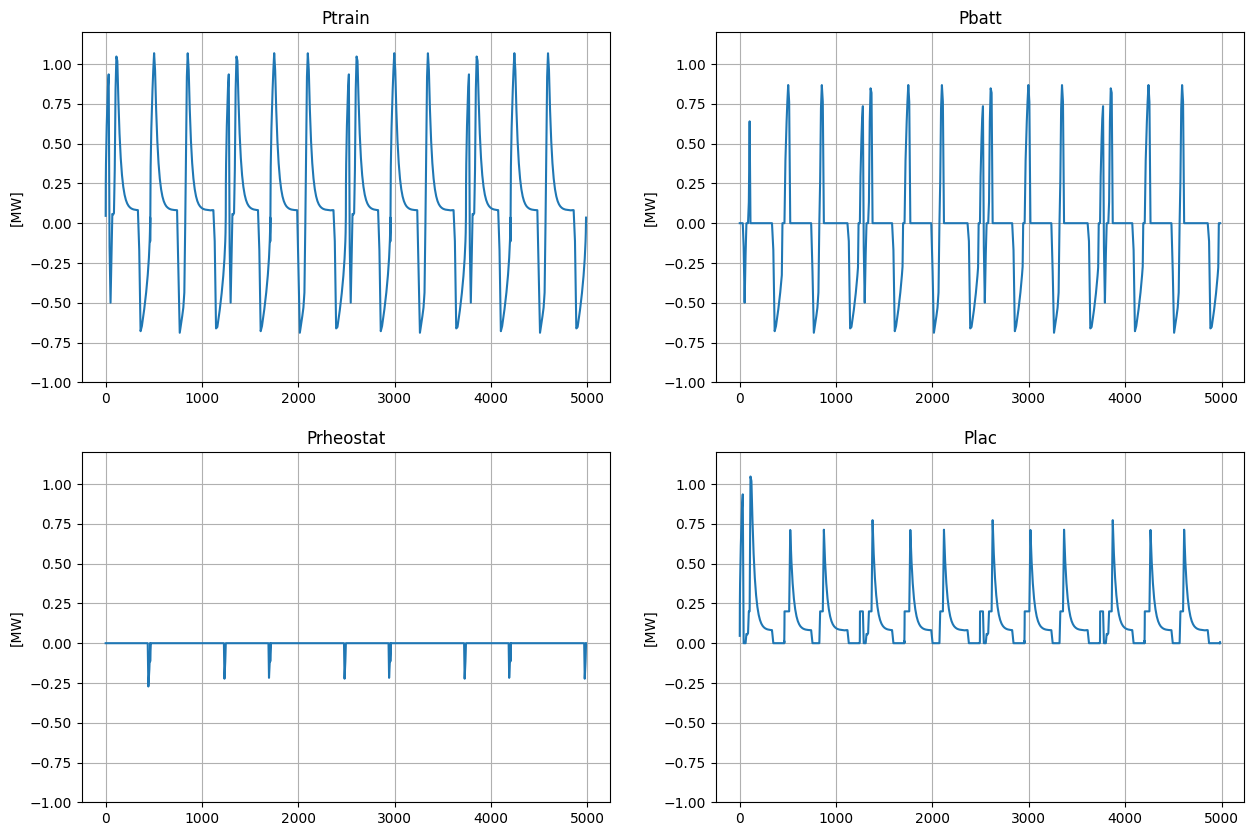

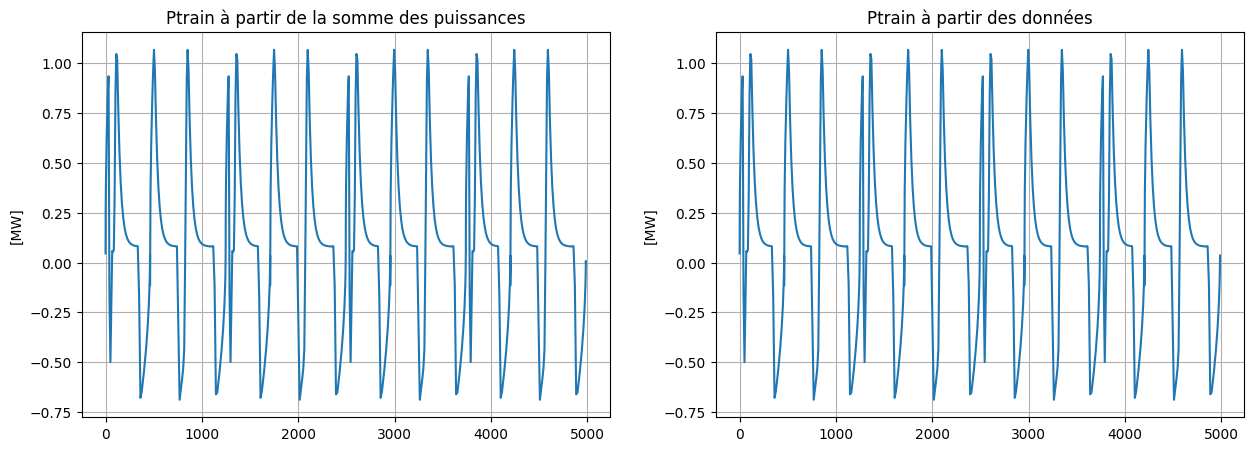

In [6]:
#Initialisation 
capa = 1*1e3*3600
rend_batt = 0.9
Ebatt = 0
Pbatt = np.zeros(len(Etrain))
Prhe = np.zeros(len(Etrain))
Plac = np.zeros(len(Etrain))
seuil_puissance = 0.2*1e6

for t in temps[:-2] :
    if Ptrain[t] <= 0 : #durant le freinage
        if Ebatt < capa :  #si la batterie n'est pas complètement chargée 
            Pbatt[t] = Ptrain[t]  #Gestion de la batterie 
            Ebatt -= (Etrain[t+1] - Etrain[t])*rend_batt  #mettre à jour l'energie de la batterie avec un rendement 

        elif Ebatt == capa :
            Prhe[t] = Ptrain[t] 
        else :
            print("L'énnergie de la batterie a depassé la capacité, remise à niveau")
            Ebatt = capa
            Prhe[t] = Ptrain[t] 

    if Ptrain[t] > 0 : #Durant l'accélération 
        
        if Ptrain[t] > seuil_puissance :
            if Ebatt> 0 :
                
                Pbatt[t] = Ptrain[t] - seuil_puissance
                Plac[t] = seuil_puissance

                E_nec = (Etrain[t+1] - Etrain[t])*(Pbatt[t]/Ptrain[t]) #Energie nécéssaire
                E_dep = E_nec*rend_batt  #Energie dépensée par la batterie pour fournir de l'énergie 
                Ebatt -= E_dep  #mettre à jour l'energie de la batterie avec un rendement 

            else : 
                Plac[t] = Ptrain[t] 

        elif Ptrain[t] <= seuil_puissance :
            Plac[t] = Ptrain[t] 

# Affichage 
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title("Ptrain")
plt.plot(position,Ptrain*1e-6)
plt.ylabel('[MW]')
plt.grid()
plt.ylim(-1,1.2)

plt.subplot(2,2,2)
plt.title("Pbatt")
plt.plot(position,Pbatt*1e-6)
plt.ylabel('[MW]')
plt.grid()
plt.ylim(-1,1.2)

plt.subplot(2,2,3)
plt.title("Prheostat")
plt.plot(position,Prhe*1e-6)
plt.ylabel('[MW]')
plt.grid()
plt.ylim(-1,1.2)

plt.subplot(2,2,4)
plt.title("Plac")
plt.plot(position,Plac*1e-6)
plt.ylabel('[MW]')
plt.grid()
plt.ylim(-1,1.2)
plt.show()


#Comparaison entre Ptrain et la somme des puissance : 
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(position, (Plac+Prhe+Pbatt)*1e-6)
plt.title("Ptrain à partir de la somme des puissances")
plt.ylabel('[MW]')
plt.grid() 
plt.subplot(1,2,2)
plt.plot(position, Ptrain*1e-6)
plt.title("Ptrain à partir des données")
plt.ylabel('[MW]')
plt.grid() 
plt.show()

**Remarques** 
L'algorithme a bien fonctionné et c'est vérifiable à partir des graphe tel que  $P_{train} = P_{LAC} + P_{rh} + P_{batt}$, en plus de ca le chargement et le déchargement de la batterie est bien clair avec les pertes dans la rhéostat quand il n'y plus d'énergie dans la batterie 

#### 2.2.2.Problème d'optimisation bi objecifs
L’optimisation bi-objectif vise à déterminer un ensemble de solutions offrant un compromis optimal entre deux critères concurrents. Dans le cadre de ce projet, il s’agit de minimiser simultanément la capacité de la batterie embarquée et la chute de tension maximale sur un trajet donné. Ce type de problème ne possède pas une unique solution optimale, mais un ensemble de solutions dites non dominées, formant le front de Pareto. Pour identifier ces solutions, deux méthodes seront utilisées, l’échantillonnage par Monte Carlo et l’optimisation par algorithme génétique. 

![Représentation général](opt.png)

##### 2.2.2.1.Mise en place de la méthode de Monte-Carlo

La méthode de Monte-Carlo va être utilisée pour pouvoir représenté l'ensemble des solutions possibles en fonction de nos deux paramètres à optimiser (la chute maximale de tension et la capacité de la batterie). Des valeurs successives de la capacité sont fixées pour pouvoir calculer les chutes maximales correspondantes.

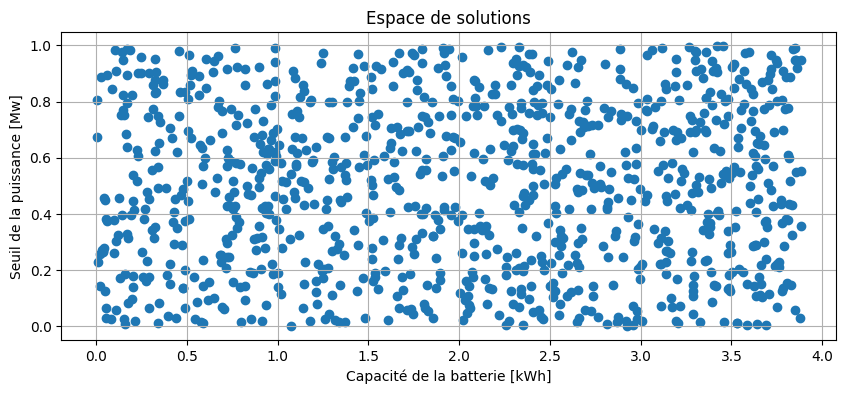

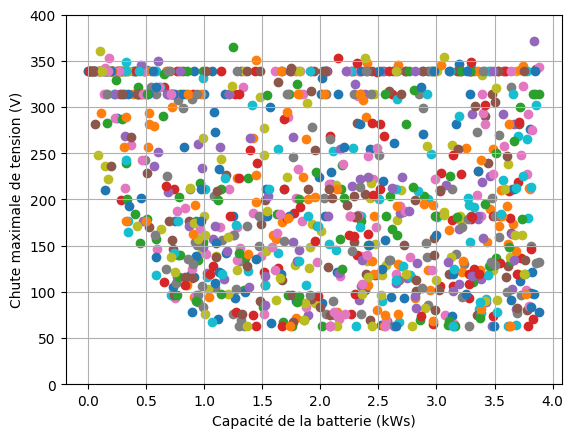

In [7]:
#Afin d'avoir es memes valeurs aléatoire 
np.random.seed(1)
#Echantillonnage aléatoire des solutions possible  
p_seuil = np.random.uniform(0,1e6, 1000)  # Générer 1000 valeurs aléatoires entre a et b
batt_capa = np.random.uniform(0,14e6, 1000)  
chutte_sys = []


#Affichage espace solution 
plt.figure(figsize=(10,4))
plt.scatter(batt_capa*1e-3/3600,p_seuil*1e-6)
plt.title("Espace de solutions")
plt.xlabel("Capacité de la batterie [kWh]")
plt.ylabel("Seuil de la puissance [Mw]")
plt.grid()


plt.figure()

for cap , s in zip(batt_capa,p_seuil):
    chute_max = simulation_sys(cap,s , Ptrain, Etrain, temps,Vsst,Req)
    chutte_sys.append(chute_max)
    plt.scatter(cap*1e-3/3600,chute_max)

plt.ylim(0,400)
plt.ylabel("Chute maximale de tension (V)")
plt.xlabel("Capacité de la batterie (kWs)")
plt.grid()

# Optimisation bi-objectif avec NSGA

L'objectif de cette méthode est de déterminer un ensemble de solutions non dominées dans un problème bi-objectif. Les étapes principales du Non-Dominated Sorting Genetic Algorithm (NSGA) sont les suivantes :  

1. **Population initiale**  
   - Générer une population aléatoire de départ dans l'espace de recherche (50 à 100 individus).  
   - Chaque individu est représenté par ses variables de décision (appelées "gènes").  

2. **Évaluation des performances**  
   - Calculer les performances (objectifs) de chaque individu.  

3. **Tri par domination non dominée**  
   - Classer les individus en rangs selon leur domination :  
     - Rang 1 : solutions non dominées.  
     - Rang 2 : solutions dominées uniquement par celles de rang 1, etc.  

4. **Sélection des meilleurs individus**  
   - Conserver les meilleurs individus selon leur rang.  
   - Utiliser un critère de distance pour éviter des solutions trop proches et bien couvrir le front de Pareto.  

5. **Opérations génétiques**  
   - **Croisement :**  
     - Créer de nouveaux individus à partir des gènes de deux parents.  
     - Pondérer aléatoirement les gènes pour introduire de la diversité.  
   - **Mutation :**  
     - Modifier légèrement certains individus pour explorer d'autres solutions.  

6. **Évolution**  
   - Répéter le processus sur plusieurs générations pour améliorer la qualité des solutions.  


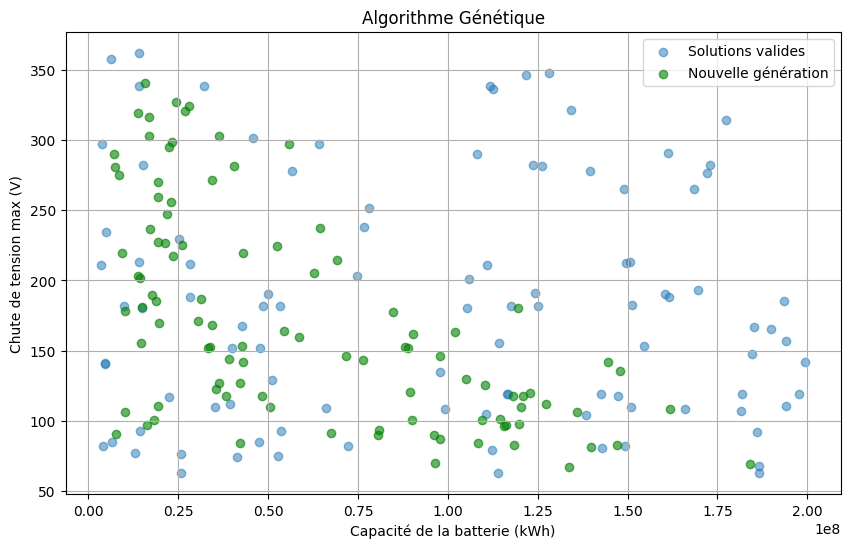

In [8]:
# **Paramètres de la simulation**
N = 100  # Nombre total de solutions initiales (population)

# **Génération aléatoire des données**
np.random.seed(1)  # Fixer une graine pour rendre les résultats reproductibles
p_seuil = np.random.uniform(0.1e6, 1e6, N)  # Générer 100 seuils de puissance aléatoires entre 0.1e6 et 1e6
batt_capa = np.random.uniform(1e6, 200e6, N)  # Générer 100 capacités de batterie aléatoires entre 1e6 et 200e6
chutte_max = []  # Liste pour stocker les chutes de tension maximales (sera remplie plus tard)

# Calculer les chutes maximales à l'aide d'une fonction fictive `simulation_sys`
# (Non définie dans le code, à adapter à votre contexte spécifique)
chutte_max = np.array([
    simulation_sys(cap, s, Ptrain, Etrain, temps, Vsst, Req)
    for cap, s in zip(batt_capa, p_seuil)
])

# **Fonction pour le tri de Pareto**
def pareto_sort(cost_matrix):
    """
    Cette fonction trie les solutions en fonction des fronts de Pareto.
    
    cost_matrix : Matrice contenant les critères des solutions (une solution par ligne)
    Retourne : Liste des fronts de Pareto (chaque front est une liste d'indices)
    """
    # Nombre de solutions dans la matrice
    num_solutions = cost_matrix.shape[0]
    if num_solutions == 0:  # Si aucune solution n'est présente
        return []

    # Initialisation
    pareto_fronts = [[]]  # Liste pour stocker les fronts de Pareto
    domination_counts = np.zeros(num_solutions, dtype=int)  # Compteur de domination pour chaque solution
    dominates = [[] for _ in range(num_solutions)]  # Liste des solutions dominées par chaque solution

    # Comparer chaque solution avec toutes les autres
    for i in range(num_solutions):
        for j in range(num_solutions):
            
            # Si la solution i domine la solution j
            if np.all(cost_matrix[i] <= cost_matrix[j]) and np.any(cost_matrix[i] < cost_matrix[j]):
                dominates[i].append(j)
            # Si la solution j domine la solution i
            elif np.all(cost_matrix[j] <= cost_matrix[i]) and np.any(cost_matrix[j] < cost_matrix[i]):
                domination_counts[i] += 1

        # Si la solution i n'est dominée par aucune autre
        if domination_counts[i] == 0:
            pareto_fronts[0].append(i)

    # Identifier les fronts suivants
    current_front = 0
    while len(pareto_fronts[current_front]) > 0:
        next_front = []  # Front suivant
        for i in pareto_fronts[current_front]:
            for j in dominates[i]:
                domination_counts[j] -= 1
                if domination_counts[j] == 0:
                    next_front.append(j)
        current_front += 1
        pareto_fronts.append(next_front)

    # Supprimer le dernier front vide
    if len(pareto_fronts[-1]) == 0:
        pareto_fronts.pop()

    return pareto_fronts

# **Créer la matrice des solutions**
# Chaque solution est une ligne contenant [capacité de batterie, chute de tension max]
Liste_solutions = np.vstack((batt_capa, chutte_max)).T

# **Appliquer le tri par domination pour trouver les fronts de Pareto**
pareto_fronts = pareto_sort(Liste_solutions)

# **Sélection d'une sous-population pour l'évolution**
population_size = N // 2  # Taille de la sous-population (50 % de la population initiale)
selected_population = []  # Liste pour stocker les indices des solutions sélectionnées
current_population_count = 0  # Compteur pour suivre la taille actuelle de la sous-population
remaining_indices = list(range(len(batt_capa)))  # Indices des solutions restantes

# Remplir la sous-population en priorisant les fronts de Pareto
while current_population_count < population_size:
    # Sélectionner les objectifs des solutions restantes
    remaining_objectives = Liste_solutions[remaining_indices]
    # Ré-appliquer le tri de Pareto
    sorted_fronts = pareto_sort(remaining_objectives)

    # Ajouter les solutions des fronts dans la sous-population
    for front in sorted_fronts:
        if current_population_count + len(front) <= population_size:
            # Ajouter toutes les solutions du front
            selected_population.extend([remaining_indices[i] for i in front])
            current_population_count += len(front)
        else:
            # Ajouter juste assez pour atteindre la taille désirée
            remaining_count = population_size - current_population_count
            selected_population.extend([remaining_indices[i] for i in front[:remaining_count]])
            current_population_count = population_size

    # Retirer les solutions sélectionnées des indices restants
    remaining_indices = [i for i in remaining_indices if i not in selected_population]

# **Opérations génétiques**
def croisement(parent1, parent2):
    """
    Effectue un croisement linéaire entre deux parents.
    """
    alpha = np.random.uniform(0, 1)  # Facteur de mélange aléatoire
    return alpha * parent1 + (1 - alpha) * parent2

def mutation(solution, mutation_rate=0.1):
    """
    Applique une mutation aléatoire à une solution.
    """
    perturbed_solution = np.copy(solution)
    if np.random.rand() < mutation_rate:  # Appliquer une mutation avec une probabilité donnée
        perturbation = np.random.uniform(-1, 1, size=len(solution))  # Ajout aléatoire
        perturbed_solution += perturbation
        perturbed_solution = np.maximum(perturbed_solution, 0)  # Forcer les valeurs à être positives
    return perturbed_solution

# **Créer la prochaine génération**
selected_solutions = Liste_solutions[selected_population]
next_generation = []

while len(next_generation) < N:
    # Sélectionner deux parents au hasard
    parent_a, parent_b = selected_solutions[np.random.choice(len(selected_solutions), 2, replace=False)]
    # Appliquer le croisement
    croi_a = croisement(parent_a, parent_b)
    croi_b = croisement(parent_b, parent_a)
    # Appliquer la mutation
    mut_a = mutation(croi_a)
    mut_b = mutation(croi_b)
    # Ajouter les enfants à la prochaine génération
    next_generation.extend([mut_a, mut_b])

# Ajuster la taille de la génération à N
next_generation = np.array(next_generation[:N])

# Extraire les nouvelles capacités et chutes de tension
new_capacities = next_generation[:, 0]
new_voltage_drops = next_generation[:, 1]

# **Visualisation des résultats**
plt.figure(figsize=(10, 6))
plt.scatter(batt_capa, chutte_max, alpha=0.5, label="Solutions valides")  # Population initiale
plt.scatter(new_capacities, new_voltage_drops, color='green', alpha=0.6, label="Nouvelle génération")  # Nouvelle génération
plt.xlabel("Capacité de la batterie (kWh)")
plt.ylabel("Chute de tension max (V)")
plt.title("Algorithme Génétique")
plt.legend()
plt.grid(True)
plt.show()